# 부트스트랩

여기 상태같이 함수를 보시면 양쪽이 다 $v_\pi$죠

여기도 $v_\pi$ 여기도 $v_\pi$ 똑같은 $v_\pi$를 똑같은 $v_\pi$를 씁니다

근데 우리가 이 $v_\pi$를 모르기 때문에 이쪽 $v_\pi$ s'을 알아야 이쪽 $v_\pi$ s를 구하는데 둘 다 모른단 말이에요

그래서 어떻게 하냐면 일단은 이쪽 거는 그냥 우리가 그냥 어떤 vk로 퉁 치고 이건 대충 추정을 한 거예요

대충 추정한 숫자로 때려 넣고 그러면은 이 s에 대해서는 우리가 s' 있고 s 다음에 s'인데 이거에 대해서는 우리가 대충 추정을 한 다음에 그 대충 추정치로 얘를 좀 더 정확한 추정치를 붙여주는 거예요

반대로 s'이 s보다 선행하는 그런 경우도 있겠죠

그러면 그때는 s의 vk를 이용해서 s'의 vk 플러스 1을 추정을 합니다

그래서 이 k가 점점 점점 증가하면 추정치가 점점 점점 더 정확해져

좀 신기하죠

그래서 이런 식으로 하는 것을 반복적 정체�평가법이라고 합니다

그래서 이런 것을 다 크게 뭉뚱그려서 부트 스트랩핑이라고 하는데요

부트 스트랩이 뭐냐면 여기 신발 뒤에 보시면 부츠 같은 경우에 끈 달려있는 신발이 있거든요

운동화 같은 거 보면은, 제 운동화는 없네요

보통 신발 뒤에 이렇게 끈 있는 거 있죠

이걸 부트 스트랩이라고 하는데 이거 언제 쓰는 거냐면 신발 신을 때 쓰는 거잖아요

근데 이제 서양 농담에 pull yourself up by your own bootstrap 이란 말이 있습니다

뭐냐면 자기 신발 끈을 양쪽을 잡고 있는 힘껏 세게 잡아당기면 하늘로 날아갈 수 있다

이런 얘기에요

말도 안 되는 소린데 약간 농담입니다

근데 원래 이게 저도 정확히 모르는데 서부 시대의 농담이었다고 해요

미국의 서부 개척 시대에 서부 개척 시대 보면 카우보이 이런 사람들이 이렇게 말 타고 다니잖아요

울타리 가 있는데 이거 울타리가 여기 문 어딨어요?

이거 울타리 뛰어넘어야 되나?

그러면은 야, 니 신발 끈 들고 이렇게 들어갖고 옮기면 되잖아?

이러면서 이제 옛날 아재 개그 같은 걸 했던 거죠 부장님 개그 그래서 자기 스스로를 들어올리는 상황인 거잖아요

여기도 보시면 이 가치를 추정해야 되는데 추정치로 이것도 추정치고 추정치로 추정치를 얻는 겁니다

그럼 계속 이거를 반복하면 아니 이것도 추정치고 이것도 추정치인데 어떻게 이걸 반복한다고 이게 정확해집니까?

놀랍게도 정확해진다는 게 수학적으로 증명이 되어 있고 그래서 시간이 많이 걸릴 뿐이지 계속 이걸 반복을 하면 됩니다

그래서 그 첫 추정치에 편향되는 문제는 있어요

그러니까 이상한 추정치로 시작하면은 진짜로 가는데 오래 걸려요

처음부터 좀 좋은 추정치로 시작하면 빨리 갈 수 있어요

그 차이가 있을 뿐이지 어쨌든 수렴을 하긴 한다

다만 처음에 약간 이상한 추정치를 가지고 하면은 추정을 하는데 좀 오래 걸린다

이런 얘기고 사실 왜 그러냐 하면 어차피 여기 r은 이거는 실제값이거든요

이거는 실제 값입니다

그러니까 이쪽이 추정치라도 이쪽이 실제 값인데 결국에는 잘 생각해 보시면 이 r을 계속 누적을 시키는 거잖아요

그러면은 아무리 여기가 부정확하더라도 어차피 결국에는 우리가 재기적 정의에 의해서 이거는 어차피 이걸 안으로 또 쪼개 보면 r 더하기 vk에 뭐 vk가 아니라 s 뭐 프라임 프라임 뭐 이렇게 된단 말이에요

그래서 어차피 결국에는 이걸 쭉 계속 반복하다 보면 r이 더해주고 더해주고 더해주는 거기 때문에 얘 자체의 영향은 별로 없게 됩니다

단지 이제 시간이 오래 걸릴 뿐이에요

그래서 이제 이런 거를 이제 부츠 스트래핑이라고 하고 요거랑 이제 비슷한 용법으로 쓰이는 경우가 있는데 컴퓨터 우리 켜면 컴퓨터 부팅 한다고 하잖아요

이것도 원래 풀레임은 부츠 스트래핑입니다

왜 그러냐 하면 컴퓨터에서 우리가 앱이나 프로그램 이런 걸 열 때 윈도우에서 보면은 예를 들면 내가 크롬을 켜고 싶다

그럼 내가 크롬 아이콘을 켜면 윈도우가 크롬을 열어줍니다

그러면은 컴퓨터를 켤 때 윈도우가 켜지는데 윈도우는 누가 켜주냐 이거야 윈도우는 스스로 켭니다

그래서 자기 자신을 뭔가

만들어내는 과정을 다 부츠 스트래핑이라고 하는 거예요

그래서 이런 식으로 하고 그러니까 이제 컴퓨터 켤 때도 부팅이라고 하고 강학습에서도 추정치고 하는 걸 부츠 스트래핑이라고 하는데 기본적으로 자기 자신에서 자기 자신이 나오는 구조를 다 이렇게 부른다 라고 생각하시면 됩니다

두 가지가 관련된 기법은 아닌데 그냥 이 부츠 스트래핑이라는 말이 일반적으로 이렇게 씁니다

그래서 요즘에 또 어떤 게 있냐면은 뭐 예를 들어 창업을 할 때 보통 우리 창업한다고 그러면 스타트업 이런 경우에 보면 어디 누구한테 투자를 100억 원을 받았다

뭐 이런 얘기 하잖아요

누구한테 투자 받아서 창업하는 경우가 있고 자기 힘으로 자기 돈 가지고 창업하는 경우가 있는데 자기 돈 가지고 창업하는 것도 부츠 스트래핑이라고 불러요

자기 돈 가지고 창업해서 회사를 잘 운영해서 돈 벌어가지고 회사를 키우면 부츠 스트래핑이라고 하고 쿠팡이나 이런 데처럼 남의 돈 가지고 손정의 돈 몇조원 받아가지고 돈 벌 때까지 계속 적잡으면서 하다가 회사 커져서 뭐 살아남으면 그런 건 부츠 스트래핑이라고 안 합니다

약간 자수성가 아 그렇죠

우리말로 치면 약간 자수성가 이런 거죠

자기 힘으로 컸다

이런 거죠

그래서 이제 우리가 동적계획법하고 부츠 스트래핑 두 가지를 알아봤는데 둘 다 보면 동적계획법도 뭔가에서 뭔가가 나오는 방식이고 부츠 스트래핑도 뭔가에서 뭔가가 나오는 방식이에요

그래서 두 개가 뭔 차이요 이렇게 생각하실 수 있는데 동적계획법은 기본적으로 s와 s프라임의 관계에 관한 겁니다

그래서 s가 최적이라면 s프라임도 최적이어야 되니까 그래서 s프라임의 최적치를 가지고 s의 최적치를 구하는데 이게 반복해서 나오니까 저장해놨다 쓰겠다

이게 이제 동적계획법에 놀리고 부츠 스트래핑은 우리가 같이 함수를 알아야 되는데 같이 함수를 잘 모르니까 일단 대충 찍어서 추정치를 해놓고 그 추정치를 가지고 더 나은 추정치를 얻겠다

이런 의미가 부츠 스트래핑입니다

그래서 이 시계에서 보시면 지금 빨간색을 칠한 부분 있죠

vk와 vk 플러스 1 이 관계를 부츠 스트래핑이라고 부르고요 지금 s프라임하고 파란색의 s 이거를 제가 이렇게 해서 여기 색깔도 표시났죠

이 관계를 동적계획법이라고 부르고요 두 가지가 합쳐져 있는 거예요

그래서 이렇게 이해를 하시면 되겠다

## SlipperyWalk

In [1]:
import gymnasium as gym
import numpy as np

class SlipperyWalk(gym.Env):
    def __init__(self, length):
        super().__init__()

        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Discrete(length)

        self.start_state = length // 2  # 2로 나눈 몫
        self.state = self.start_state
        self.done = False
        self.truncated = False
        self.length = length
        self.P = self.set_transition()

    def set_transition(self):
        P = {}
        transition_probs = {'MOVE': 1/2, 'STAY': 1/3, 'OPPOSITE': 1/6}
        goal = self.length - 1

        for s in range(self.length):
            P[s] = {}
            for a in range(2):
                if s == 0:
                    P[s][a] = [(1.0, s, 0, True)]  # 확률, 상태, 보상, 종료 여부
                elif s == goal:
                    P[s][a] = [(1.0, s, 1, True)]
                else:
                    transitions = []
                    for transition, prob in transition_probs.items():
                        if transition == 'MOVE':
                            next_state = s + 1 if a == 1 else s - 1
                        elif transition == 'STAY':
                            next_state = s
                        elif transition == 'OPPOSITE':
                            next_state = s - 1 if a == 1 else s + 1
                        next_state = max(0, min(goal, next_state))   # 범위 제한 표현
                        reward = 1 if next_state == goal else 0      # 삼항 연산자
                        done = next_state == 0 or next_state == goal
                        transitions.append((prob, next_state, reward, done))
                    P[s][a] = transitions

        return P

    def reset(self):
        self.state = self.start_state
        self.done = False
        self.truncated = False
        self.steps = 0
        return self.state, {}

    def step(self, action):
        transitions = self.P[self.state][action]
        probs = np.array([t[0] for t in transitions])
        i = np.random.choice(np.arange(len(transitions)), p=probs)
        _, self.state, reward, self.done = transitions[i]
        self.steps += 1
        self.truncated = self.steps >= 100
        return self.state, reward, self.done, self.truncated, {}

    def render(self, mode='human'):
        grid = ['X'] + ([' '] * (self.length - 2)) + ['O']  # 리스트 연산
        grid[self.state] = 'A'
        print('|' + '|'.join(grid) + '|') # 문자열 연산

    @property
    def unwrapped(self):
        return self



그래서 우리가 이제 여기 코드에 보시면 중간에 굉장히 복잡하게 그 set transition 이라는 함수가 있는데요 얘가 뭘 하냐면 전이 함수를 정의하는 부분입니다

그래서 이 set transition 함수를 실행을 하면 그 결과를 .p 에다가 저장을 하거든요

그래서 이 대문자 p가 최종적으로 만들어진 전이 함수에요

그래서 그거를 보시려면 `env.P` 이렇게 하시면 이게 전이 함수인데 이 구존을 좀 잘 기억을 해 두셔야 됩니다

환경 생성

In [2]:
env = SlipperyWalk(9)

리셋

In [3]:
env.reset()

(4, {})

왼쪽으로 한 걸음

In [4]:
env.step(0)

(3, 0, False, False, {})

그리기

In [5]:
env.render()

|X| | |A| | | | |O|


무조건 왼쪽으로 걷는 정책

In [ ]:
LEFT, RIGHT = 0, 1
pi = {
    s: LEFT
    for s in range(env.observation_space.n)
}

끝까지 반복하기

In [ ]:
state, info = env.reset()
terminated = False
while not terminated:
    action = pi[state]
    s, _, terminated, _ = env.step(action)
    env.render()

## 정책 평가

In [6]:
def policy_evaluation(pi, P, gamma=1.0, theta=1e-10):
    # pi: 정책, P: 전이확률, gamma: 할인율, theta: 수렴 판정 기준
    nS = len(P)  # 상태의 수
    prev_V = np.zeros(nS)  # ns와 크기가 같은 영(0)벡터
    while True:  # 무한 루프
        V = np.zeros_like(prev_V)  # prev_V와 모양이 같은 영벡터
        for s in range(nS):
            for prob, next_state, reward, done in P[s][pi[s]]:
                rtrn = reward + gamma * prev_V[next_state] * (not done)
                # not done은 done이 False일 때 1, True일 때 0
                V[s] += prob * rtrn
        if np.max(np.abs(prev_V - V)) < theta: # 기존 V와 차이가 작으면 중단
            break
        prev_V = V.copy()
    return V



어 이제 정책 평가를 보면은 여기 이제 파이를 봤구요

파이는 여기 정책입니다

정책이고 그 다음에 여기 p 는 뭐냐면 이건 전이 확률이에요

그 다음에 간마는 오늘 퀴즈에서도 했지만 할인 할인율이죠

어 그 다음에 여기 이제 세타는 뭐냐면 우리가 이제 수렴 판별 기준입니다

우리가 이 정책 평가를 같이 해서 같이를 추정하는 걸 계속 반복하면 언젠가 수렴한다고 했잖아요

그러면은 그거를 우리가 수렴을 했는지 안 했는지 어떻게 하느냐 같이 해서 같이를 추정을 했는데 아까랑 지금이랑 추정치가 똑같다

그러면 이제 수렴이 된 거죠

아까도 10이었는데 지금도 10이야

그러면 다음번에 또 10이겠죠

그러니까 더 추정을 안 해도 됩니다

근데 이제 이게 논리적으로는 완전 0이 될 때까지 해야 되는데 이게 보통 어떻게 되냐면 수렴을 할 때 요렇게 되거든요

그러면 여기까지 가려면 너무 오래 걸리니까 어떤 세타를 정해가지고 세타 이하로 가면은 뭐 거의 다 왔으니까 여기서 그냥 그만두자

이거죠

세타가 지금 1 2 마이너스 10 이렇게 썼는데요 요거는 10에 마이너스 10 승 이란 뜻입니다

그럼 이 정도면은 뭐 다 왔다고 해도 되겠죠

뭐 거의 0이잖아요

0.000000000001 이니까 그래서 좀 더 빨리 스탑하고 싶으시면은 요걸 마이너스 10 대신에 뭐 마이너스 5나 이렇게 하면 좀 더 빨리 스탑 하겠죠

우리가 뭐 가치를 엄청 정확하게 추정할 경우 필요는 대부분 그렇게 없거든요

적당히 알면 됐으니까 요거는 이제 세타까지만 추정하게 됩니다

평가

In [8]:
V = policy_evaluation(pi, env.P)
V

array([0.00000000e+00, 3.04878027e-04, 1.21951212e-03, 3.96341448e-03,
       1.21951217e-02, 3.68902434e-02, 1.10975609e-01, 3.33231707e-01,
       1.00000000e+00])


0번 상태는 0번 왼쪽으로 가고 1번 상태도 0번 왼쪽으로 가고 2번 상태도 0번 왼쪽으로 가고 3번 상태도 0번 왼쪽으로 항상 왼쪽으로 가는 정책 굉장히 최악의 정책이라고 할 수 있겠죠

최악의 정책으로 해도 어쨌든 가치는 있습니다

우리가 우연히 미끄러져서라도 오른쪽으로 갈 수 있으니까 희박하지만 확률은 계산을 해보면 폴리시 벨루에이션을 해보면 금방 수렴을 하는데 양쪽 끝은 어차피 의미가 없고 여기 맨 오른쪽 보시면 골대 바로 옆에 있는 자리는 한 3.33 이러고 여기 10에 마이너스 1승 이렇게 되는데 완전히 3.333 이렇게 가는 거 아니고 그거보다 살짝 작은 정도로 0.333, 23, 17, 0.7 이렇게 가는 거죠

그래서 거의 한 가치가 그래도 1%는 된다

이런 얘기고 우리가 처음에 시작할 때는 1%였는데 거의 1% 정도까지 올라가는 거죠

왜냐하면 왼쪽으로 갔다가도 다시 오른쪽으로 갈 수 있으니까 그렇습니다

그다음에 얘는 그거보다 이제 더 작죠

이거는 1.1% 이렇게 해서 점점 가치가 작아져서 여기까지 가면은 가치가 10에 마이너스 4승 곱하기 3.04니까 0.0003 이렇게 되겠죠

근데 우리가 이제 보통 중간에서 시작하니까 1, 2, 0, 1, 2, 3, 4 여기가 이제 우리가 중간에서 시작하거든요

중간에서 딱 시작하자마자 우리의 가치는 사람으로 치면 태어나자마자 가치는 1.2 곱하기 10에 마이너스 2승 그러니까 0.01 이 정도 되는 거죠 태어났을 때부터 별로 그렇게 가치가 높은 상황이 아닙니다


근데 이제 여기 재밌는 점이 하나 있어요

뭐냐면 우리 지금 최악의 정책을 쓰고 있거든요

최악의 정책을 쓰고 있는데 이 정책의 가치 평가를 해보니까 그 와중에도 내가 여기 있거든요

그럼 내 정책은 왼쪽으로 가는 정책이에요

자 보시면 왼쪽으로 가는 정책이라서 난 여기서 출발을 하는데 내 정책은 이리로 가거든요

그럼 심지어 내 정책이 최악의 정책이지만 그 정책으로 가치 평가를 해봐도 이쪽으로 가는 거는 굉장히 어리석은 짓이에요


왜냐하면 내가 지금 현재 가치가 10에 마이너스 2승인데 10에 마이너스 3승인데 로 간단 말이에요

내 정책은 바보 같은 짓이잖아요

왜 가치를 더 낮춥니까?

내 정책으로 평가해봐도 나는 지금 가치를 낮추는 선택을 하고 있단 말이에요

근데 오른쪽으로 가면 가치가 더 높아지거든요

1.2에서 3.6으로 가치가 높아져요

내 정책이 굉장히 나쁜 정책임에도 불구하고 그렇게 평가를 해보면 더 높은 가치를 가지는 선택이 어쨌든 있다는 거죠

그러면 정책을 어떻게 바꾸면 됩니까?

나는 왼쪽으로 가는데 오른쪽으로 가는 걸로 바꾸면 되겠죠


심지어 내 정책이 나쁜 정책임에도 불구하고 그러면 내 정책을 바꿀 수 있는 거죠

그래서 정책의 가치를 평가를 해보면 내 정책을 어떻게 개선해야 될지 알 수 있습니다

내 정책이 아무리 나빠도 이게 환경이 전이 함수가 확률적이라고 하면 내가 우연히 나쁜 행동을 해도 좋은 결과가 나오는 경우가 있어요

그래서 그것 때문에 나는 왼쪽으로 가는 정책을 가지지만 전이 함수가 확률적이 아니면 무조건 왼쪽으로만 가기 때문에 전부 상태가 가치가 0이어야 되거든요

왜냐하면 무조건 0으로만 가니까 근데 지금 우연히 오른대가 오른쪽으로 가는 경우가 있기 때문에 하여간 이 상태가 그래도 가치가 좋게 됩니다

그러면 하여간 이리로 가야 되는 거죠

그래서 우리가 가치평가만 정확하게 되면 아무리 나쁜 정책을 가지고 시작을 해도 최적 정책을 항상 찾을 수가 있습니다

## 정책 반복법 


그래서 우리가 정책 반복법이라는 게 여기서 나오는데 일단 아무 정책이나 가지고 시작을 합니다

아무 정책이나 가지고 시작을 해서 반복적 정책 평가를 해요

앞에 있던 것처럼 그럼 이제 가치함수를 얻었으니까 우리가 아무리 나쁜 정책을 가지고 있어도 그 가치를 보면 가치가 좀 더 높은 상태로 가는 행동이 있을 거란 말이에요

그래서 가치가 높은 행동을 하도록 정책을 개선을 합니다


그런 식으로 계속 뒤집어주고 뒤집어주고 하다 보면 언젠가는 더 이상 개선되지 않을 때가 있어요

더 이상 개선되지 않는 때가 뭡니까?

최적 정책이죠

이것보다 더 좋은 선택이 없는 상태에 도달하게 됩니다

그래서 최적 정책 아까 얘기했죠 더 좋은 상태가 없다고 그래서 왜 항상 수렴하냐면 최적 정책을 정의를 가만히 생각해보시면 이게 수학적으로 증명하는 건 어렵지만 논리를 가만히 생각해보시면 수렴할 수밖에 없어요

왜냐하면 최적 정책은 반드시 존재하고 그것보다 더 좋은 정책이 없거든요

바꾸면 천정이 있어요

우리가 정책을 개선할 때마다 무조건 조금씩 좋아지잖아요

아주 작은 숫자라도 조금씩 좋아지잖아요

그럼 조금씩 좋아지다 보면 언젠가는 천정이 있으니까 이 천정까지 가면 더 이상 못 올라가잖아요

그 점이 있겠죠

개선을 하다 하다 보면 아무리 올라가도 천장에 부딪히게 되어있습니다

그래서 엄밀하게 증명하기도 힘들지만 그냥 생각해보면 정의상 이 끝에 가면 최적 정책까지 도달하게 된다

그래서 이것을 정책 반복이라고 합니다

In [9]:
def policy_improvement(V, P, gamma=1.0):
    nS = len(P) 
    nA = len(P[0])  # 행동의 수
    Q = np.zeros((nS,nA))
    for s in range(nS):
        for a in range(nA):
            for prob, next_state, reward, done in P[s][a]:
                rtrn = reward + gamma * V[next_state] * (not done)
                Q[s][a] += prob * rtrn
    new_pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    return new_pi

평가된 가치를 바탕으로 정책 개선

In [10]:
improved_pi = policy_improvement(V, env.P)
improved_pi

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0}

개선된 정책의 평가

In [11]:
improved_V = policy_evaluation(improved_pi, env.P)
improved_V

array([0.        , 0.66676829, 0.88902439, 0.96310976, 0.98780488,
       0.99603659, 0.99878049, 0.99969512, 1.        ])

정책 반복

In [13]:
def policy_iteration(env, gamma=1.0, theta=1e-10):
    pi = random_policy(env)
    P = env.unwrapped.P
    while True:
        old_pi = dict(pi)
        V = policy_evaluation(pi, P, gamma, theta)
        pi = policy_improvement(V, P, gamma)
        if old_pi == pi:
            break
    return V, pi


In [14]:
def random_policy(env):
    return {s: env.action_space.sample() 
            for s in range(env.observation_space.n)}

policy_iteration(env)

(array([0.        , 0.66676829, 0.88902439, 0.96310976, 0.98780488,
        0.99603659, 0.99878049, 0.99969512, 1.        ]),
 {0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0})

### FrozenLake 환경에서 실험

In [15]:
env = gym.make('FrozenLake-v1', render_mode="rgb_array")

def print_policy(pi, n_rows, n_cols, action_symbols):
    for i in range(n_rows):
        for j in range(n_cols):
            action = pi[i * n_cols + j]
            print(action_symbols[action], end=' ')
        print()


In [16]:
import tqdm

def count_success(pi, env):
    total_reward = 0
    for _ in tqdm.trange(100):
        state, _ = env.reset()
        terminated = False
        while not terminated:
            action = pi[state]
            state, reward, terminated, truncated, info = env.step(action)
        else:
            total_reward += reward
    return total_reward / 100


무작위 정책

In [17]:
pi = random_policy(env)
print_policy(pi, 4, 4, '←↓→↑')
count_success(pi, env)

↓ → ↑ → 
↑ ↑ ↓ ↓ 
← ← ↑ ↓ 
↑ ↓ ↑ ↓ 


100%|██████████| 100/100 [00:00<00:00, 11743.49it/s]


0.0

정책 반복으로 개선된 정책

In [18]:
V, pi = policy_iteration(env)
print_policy(pi, 4, 4, '←↓→↑')
count_success(pi, env)

← ↑ ↑ ↑ 
← ← ← ← 
↑ ↓ ← ← 
← → ↓ ← 


100%|██████████| 100/100 [00:00<00:00, 3106.52it/s]


0.82


그리고 여기 0.8 이렇게 나오는 건데 이게 성공률이라서 0.8이면 성공률이 80%입니다

100번 하면 80번은 꼴때까지 간다

그래서 우리가 무작위 정책을 했을 때 100번 해서 한 번도 못 가던 거를 그냥 한 줄만 짜서 돌리면 100번 중에 80번 성공하는 정책을 최적 정책을 그것도 찾을 수가 있습니다

### CliffWalking으로 실험

In [19]:
env = gym.make("CliffWalking-v0", render_mode="rgb_array")
V, pi = policy_iteration(env, 0.9)
print_policy(pi, 4, 12, '↑→↓←')

→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → 


그래서 여기서도 폴리시 이터레이션을 하는데 아 여기 감마를 왜 0.9로 설정했을까요? 할인율을 낮추면 어떻게 돼요? 할인율을 낮추면 긴급성이 높아진다. 그래서 보상을 빨리 받으려고 하는 성향이 생긴다

근데 할인율을 1.0 이러면 이렇게 해서 가든 이렇게 가든 이렇게 가든 어차피 보상은 여기 가서 플러스 1이기 때문에 언제 받아도 플러스 1이거든요. 할인율이 1이면 그러니까는 빨리 갈 필요가 없죠.

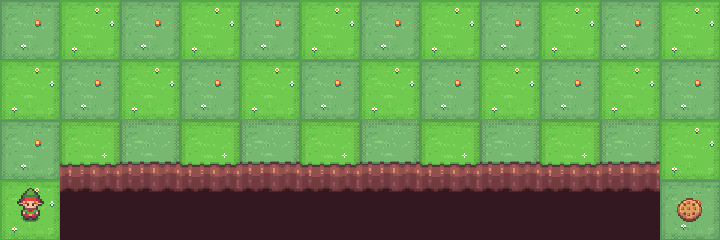

In [22]:
import imageio
from IPython.display import Image

state, _ = env.reset()
frames = []
frames.append(env.render())
terminated = False
while not terminated:
    action = pi[state]
    state, reward, terminated, truncated, info = env.step(action)
    frames.append(env.render())
filename = 'animation.gif'
imageio.mimsave(filename, frames, fps=2)
Image(filename)

## 가치 반복

정책 반복은 정책을 우리가 정책이 있으면 정책을 평가를 하고 평가를 하는데 그 가치를 잘 모르니까 일단 대충 추정을 해놓고 그 추정치를 계속 다음 추정치를 추정하는데 쓰는 방식으로 추정치를 계속 개선을 하다가 더 이상 추정치가 변하지 않으면 거기서 스탑을 합니다.

그러면 평가된 정책에서 가치가 높은 행동들이 있으니까 그걸 바탕으로 정책을 개선을 하는 거죠.

그래서 개선된 정책을 가지고 다시 평가를 합니다.

그리고 또 이걸 계속 반복을 하다가 더 이상 개선이 안 되면 스탑 이렇게 하는 거죠

그래서 이게 정책 반복인데 가만히 생각을 해보니까 정책 평가 단계에서 정책을 수렴할 때까지 정확한 가치를 평가를 하려고 하는데 의문이 생기는 거죠.

그렇게까지 정확한 가치를 추정할 필요가 있을까?

왜냐하면 우리는 이 정책은 어차피 금방 개선할 거잖아요.

그러면 대충만 맞으면 되지

사실 평가 단계에서 추정을 엄청 정확하게 하는 건 시간 낭비 라는 말이에요.

특히 초반에는 정책이 별로 안 좋은 정책일 거니까 어차피 안 좋은 정책의 각각의 가치를 평가한다고 너무 많은 시간을 쓰는 것이 그렇게 좋은 방법은 아닌 것 같다고 봅니다.

그래서 이제 가치 반복이라는 방법인데요.

가치 반복은 우리가 앞에서 정책 반복과 마찬가지로 가장 가치가 큰 행동을 하는 방식으로 정책을 수정을 하는데 정책을 수정할 때 그냥 가치까지 같이 수정을 합니다.

그래서 우리가 행동은 욕을 한다 치고 그러면 행동을 욕을 한다는 전제로 가치도 그거에 따라서 매겨버리는 거죠

그래서 보시면은 이제 뭐가 다르냐 똑같은 얘기 아니야?

이렇게 생각하실 수 있는데 앞에랑 식을 보시면 미묘하게 달라요.

정책 평가를 보면 여기서 우리 실제 파이가 들어가거든요.

원래는 123쪽을 보시면 우리가 정책 평가를 할 때 여기 실제 우리가 가진 정책을 가지고 그 확률을 곱해서 가치를 구하잖아요.

근데 137쪽으로 넘어오셔서 가치 반복을 보면 여기서 우리 실제 파이를 쓰지 않습니다.

그냥 요구 계산을 해가지고 바로 최적 행동을 바로 뽑아내요.

그리고 최적 행동을 바로 그냥 가치에다가 대입을 해버립니다.

그러면 이 vk가 수렴할 때까지 반복을 하지 않기 때문에 일단 이게 가치가 정확하지 않겠죠.

그리고 요 행동도 정확하지 않을 겁니다.

근데 이제 재밌는 건 뭐냐면 둘 다 별로 정확하지 않은데 어차피 또 반복을 계속하면은 결국에는 또 수렴을 합니다.

신기하게도 그래서 우리 여기 공식을 잘 보시면 파이가 없죠.

그래서 우리 기존의 그냥 정책은 무시하고 싹 다 무시하고 어차피 우리는 그 정책 업데이트 할 거니까 그 정책 무시하고 그냥 현재 상태로 가치가 제일 높은 걸 한다고 치고 그럼

가치가 제일 높은 걸 한다고 친 상태로 다음 가치 추정치도 수정을 하는 이런 방식입니다.

그래서 이게 이제 강화학습의 가장 기본적인 아이디어 우리가 지금까지 한 건 약간 빌드업인데 계속 빌드업이긴 합니다만 이제 우리가 여러 가지 논리를 배웠죠.

동적계획법의 논리도 배우고 그 다음에 정책 반복법의 논리도 배우고 그 다음에 이제 가치 반복까지 왔는데 이런 식으로 우리가 이제 추정을 하게 됩니다.

그리고 이제 이 공식 이 부분 이 부분은 계속 중요해요.

그래서 결국에는 이게 vk가 되느냐 k 플러스 되느냐일 뿐이지 아침부터 하고 있는 요 재귀적 정의 보상에다가 플러스 할인 곱하기 가치 요 식은 계속 반복이 됩니다.

근데 이제 여기서 가치를 v로 할 거냐 v파이로 할 거냐 vk로 할 거냐

이거에 따라서 이제 알고리즘이 조금씩 바뀌는 거지 이 핵심 아이디어는 계속 유지가 되는 거예요.

다른 거는 뭐 앞뒤로 여기가 바뀌고 뭐 이래도 이건 안 바뀌죠.

그래서 이제 가치 반복법을 구현을 해보면 그래서 가치 반복은 이게 정책 평가랑 정책 개선이 동시에 이루어집니다.

한방에 이루어지고 그래서 여기 보시면은 코드에 보시면은 이제 q를 추정을 해요.

q는 뭐라고 그랬죠?

행동가치를 추정을 합니다.

행동가치를 추정을 하는데 어 요 v는 이제 그 기존의 v에요.

기존의 v 기존 부위를 가지고 기존 상태 가치를 가지고 행동가치를 추정을 합니다.

그래서 v는 바로 어떻게 되냐면 q에 그냥 최대 값으로 다 덮어 써버려요.

원래 부위가 있었죠.

원래 부위가 있었는데 v를 덮어 쓴 덮어 쓰는데 뭘로 덮어 쓰냐면 q에 최대 값으로 덮어 쓴다.

왜냐하면 어차피 나는 가장 가치가 높은 행동만 할 거니까 나는 다른 행동은 안 해.

가치가 제일 높은 행동만 할 거야.

그러니까는 상태 가치는 무조건 이걸로 덮어 쓰게 됩니다.

그래서 보시면은 그 요 공식 전체의 파이가 들어가는 부분이 아무것도 없어요.

내 정책 같은 거는 고려 사항이 아닙니다.

그리고 어 여기 이제 파이는 이제 사후적으로 어차피 v가 결정되면 파이도 결정이 되니까 어차피 내가 제일 가치가 높은 행동만 할 거잖아요.

그래서 파이는 이제 사후적으로 결정되는 거지.

이 함수에는 파이가 아예 들어가는 게 없어요.

그래서 이것도 해 보시면은 뭐 당연하지만 정책 반복하고 마찬가지로 똑같이 수렴을 하기 때문에 결과는 어차피 똑같습니다.

그래서 우리가 밸류 이터레이션 이거를 여기 지금 이 엠 브이는 뭐죠

In [24]:
def value_iteration(env, gamma=1.0, theta=1e-10):
    P = env.unwrapped.P
    nS = env.observation_space.n
    nA = env.action_space.n
    V = np.zeros(nS)
    while True:
        Q = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                for prob, next_state, reward, done in P[s][a]:
                    Q[s][a] += prob * (reward + gamma * V[next_state] * (not done))
        if np.max(np.abs(V - np.max(Q, axis=1))) < theta:
            break
        V = np.max(Q, axis=1)
        pi = {s:a for s, a in enumerate(np.argmax(Q, axis=1))}
    return V, pi


In [25]:
V, pi = value_iteration(env)
print_policy(pi, 4, 12, '↑→↓←')

↑ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
→ → → → → → → → → → → ↓ 
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ → → 



지금 클리프워크죠.

클리프워크에 적용해 보시면은 오른쪽으로 쭉 가는 거로 정책 반복이랑 똑같은 게 되고 어 우리가 이거를 프로즌 레이크에 해 보고 싶으시면 그냥 엠 브이만 프로즌 레이크로 하셔가지고 똑같이 밸류 이터레이션을 하시면 올바른 정책을 찾아줍니다.

## 퀴즈

<iframe src="https://tally.so/embed/mRR7BP?alignLeft=1&hideTitle=1&transparentBackground=1&dynamicHeight=1" loading="lazy" width="100%" height="1900" frameborder="0" marginheight="0" marginwidth="0" title="[RL] 가치"></iframe>